In [0]:
!wget http://memorability.csail.mit.edu/lamem.tar.gz

--2019-12-04 13:28:51--  http://memorability.csail.mit.edu/lamem.tar.gz
Resolving memorability.csail.mit.edu (memorability.csail.mit.edu)... 128.30.195.49
Connecting to memorability.csail.mit.edu (memorability.csail.mit.edu)|128.30.195.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2708368436 (2.5G) [application/x-gzip]
Saving to: ‘lamem.tar.gz’

lamem.tar.gz        100%[===================>]   2.52G  15.4MB/s    in 2m 52s  

2019-12-04 13:31:44 (15.0 MB/s) - ‘lamem.tar.gz’ saved [2708368436/2708368436]



In [0]:
!tar -xf /content/lamem.tar.gz

In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Imports**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io,transform
import torch
from tqdm import tqdm
import os
import time
import torch.nn.functional as F

from torch.optim import lr_scheduler
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils,models
import copy
from skimage import io, transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
dataset_train=pd.read_csv("/content/drive/My Drive/image memorability/dataset/train_dataset.csv")
dataset_validation = pd.read_csv("/content/drive/My Drive/image memorability/dataset/validation_dataset.csv")

In [0]:
device

device(type='cuda', index=0)

In [0]:
model_50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.2MB/s]


In [0]:
model_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## **Defining model**

In [0]:
model_50 = models.resnet50(pretrained=True)
for param in model_50.parameters():
  param.requires_grad = False
import torch.nn as nn
 
n_inputs = model_50.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_50.fc = last_layer
model_50.to(device)
print(model_50.fc.out_features)



1


# **LoadModel**

In [0]:

# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
weights_dict= torch.load("/content/drive/My Drive/image memorability/bestmodel50.pt")

RuntimeError: ignored

In [0]:
model_50.load_state_dict(weights_dict["model_state_dict"])


<All keys matched successfully>

In [0]:
model_50=model_50.to(device)

In [0]:
model_50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
#defining hook
feature_blobs = []
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())

In [0]:
finalconv_name="layer4"

In [0]:
model_50._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [0]:
# feature_blobs

In [0]:
params = list(model_50.parameters())

In [0]:
weight_softmax = np.squeeze(params[-3].cpu().data.numpy())

In [0]:
params[-3].shape

torch.Size([2048])

In [0]:
weight_softmax

array([0.00839419, 0.05489472, 0.03475161, ..., 0.02194775, 0.02065102,
       0.00762452], dtype=float32)

In [0]:
weight_softmax.shape

(2048,)

In [0]:
Loading dataset

## **Loading dataset**

In [0]:
# columns={'name' : 'X' ,'score':'y'}
# dataset = pd.read_csv("/content/saved_file.csv")
# dataset.rename(columns=columns,inplace=True)

In [0]:
# #train validation split
# from sklearn.model_selection import train_test_split
# dataset_train,dataset_validation =train_test_split(dataset,test_size=0.2)

In [0]:

class AsetheticsDataset(Dataset):
  '''asethitics dataset'''
  def __init__(self,dataframe,root_dir,transform=None):
    """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.data = dataframe
#     self.data.rename(columns=columns,inplace=True)
#     self.data.drop(self.data.columns[[1,2,3,4,5,6,8,9]] , axis=1,inplace=True)
    self.root_dir = root_dir
    self.transform = transform
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,idx):
   
    if torch.is_tensor(idx):
      idx = idx.tolist()
   
    image_name =  os.path.join(self.root_dir,self.data.iloc[idx,0])
    image = io.imread(image_name)
    mem_val = self.data.iloc[idx,1]
#     return_sample={}
    return_sample = {
          'image':image,
          'memorability_score':mem_val 
    }
    if self.transform:
      return_sample = self.transform(return_sample)

     
    return return_sample

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        
        image,mem_val = sample['image'], sample["memorability_score"]
        
        h, w = image.shape[:2]
        
        # if isinstance(self.output_size, int):
        #     if h > w:
        #         new_h, new_w = self.output_size * h / w, self.output_size
        #     else:
        #         new_h, new_w = self.output_size, self.output_size * w / h
        # else:
        #     new_h, new_w = self.output_size

        # new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (self.output_size,self.output_size,3))
        return {'image': img, 'memorability_score': mem_val}
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image, mem_val = sample['image'], sample['memorability_score']
#         print(type(torch.from_numpy(image)))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         print(image.shape)
      
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'memorability_score': mem_val}
class Normalize(object):
  def __init__(self,mean,std):
    self.mean=mean
    self.std=std
  def __call__(self,sample):
    image, mem_val = sample["image"], sample["memorability_score"]
    normalized=  (image -self.mean) / self.std
    return {
        "image":normalized,
        "memorability_score" : mem_val
    }

In [0]:

# transformed_dataset_train = AsetheticsDataset(dataset_train,root_dir="/content/lamem/images",
#                                         transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
#                                                           ]))

# transformed_dataset_val= AsetheticsDataset(dataset_validation,root_dir="/content/lamem/images",
#                                         transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
#                                                           ]))

# train_dataloader=DataLoader(transformed_dataset_train,batch_size=128,shuffle=True)
# validation_dataloader=DataLoader(transformed_dataset_val,batch_size=128,shuffle=True)

In [0]:
# image_tensor =  next(iter(validation_dataloader))

In [0]:
# image_tensor["image"].doub

In [0]:
#IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'
IMG_URL="https://brandhero.com.au/wp-content/uploads/2016/03/memorable.jpg"
#IMG_URL="https://www.jeffbullas.com/wp-content/uploads/2019/09/How-I-Improved-The-Memorability-Of-My-Brand-With-This-Simple-Change.jpg"

In [0]:
#IMG_URL="https://image.neosperience.com/0dde5eaf8c7b748f9a56c4a55985f49c.png"

In [0]:
IMG_URL="http://memorability.csail.mit.edu/imgs/7.jpg"

In [0]:
IMG_URL="https://www.theglobeandmail.com/resizer/sfvhChdiueia3mIyfjb_e4iC8dM=/1200x0/filters:quality(80)/arc-anglerfish-tgam-prod-tgam.s3.amazonaws.com/public/IFNR4D7X7VF5JOCETHZSTYPVBY"

In [0]:
IMG_URL="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQPojvpYqnEqlD_YtvnlqsBiHCwlsturQjCCvPWg4B3AJ7Pr7Q2&s"

In [0]:
IMG_URL="https://www.stockvault.net/data/2011/01/01/116800/thumb16.jpg"

In [0]:
IMG_URL ="https://images.unsplash.com/photo-1510525009512-ad7fc13eefab?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80"

In [0]:
IMG_URL="https://images.huffingtonpost.com/2016-04-18-1460992862-2887201-iStock_000022162723_Small-thumb.jpg"

In [0]:
IMG_URL="https://images.livemint.com/img/2019/06/05/600x338/2019-05-17T050331Z_2_LYNXNPEF4F1C0_RTROPTP_3_LINKEDIN-M-A-MICROSOFT_1559738873813_1559738882968.JPG"

In [0]:
normalize =  transforms.Normalize((0.5,), (0.5,))
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [0]:
import requests
from PIL import Image
import io

In [0]:
io.BytesIO(response.content)

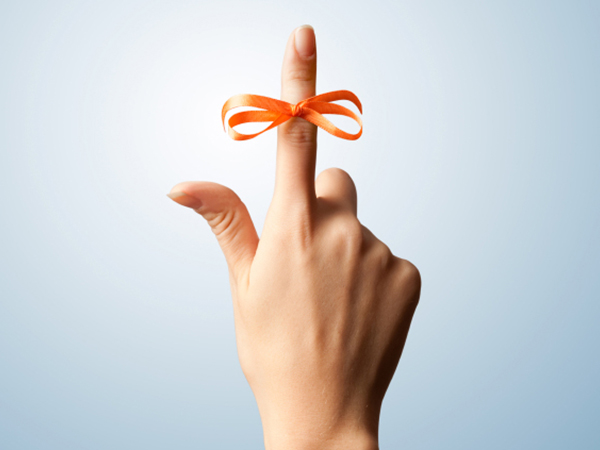

In [0]:
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')
img_pil

In [0]:
img_tensor = preprocess(img_pil)
img_tensor = img_tensor.to(device)
img_tensor=img_tensor.unsqueeze(0)
mem_score = model_50(img_tensor)
mem_score

tensor([[0.9013]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
size_upsample = (224, 224)
bz, nc, h, w = feature_blobs[-1].shape
cam = np.dot(weight_softmax.reshape(1,-1),feature_blobs[-1].reshape((nc, h*w)))
cam = cam.reshape(h, w)

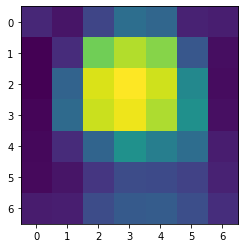

In [0]:
plt.imshow(cam)

In [0]:
cam = cam - np.min(cam)
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)

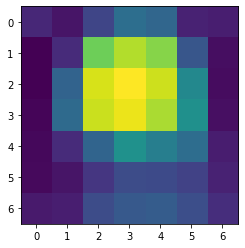

In [0]:
plt.imshow(cam_img)

In [0]:
up_sampled_image =cv2.resize(cam_img, size_upsample) 


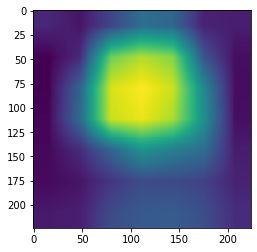

In [0]:
plt.imshow(up_sampled_image)

In [0]:
# heatmap = cv2.applyColorMap(cv2.resize(up_sampled_image,(width, height)), cv2.COLORMAP_JET)

In [0]:
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(up_sampled_image,(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

True

In [0]:
img = Image.open("./CAM.jpg")

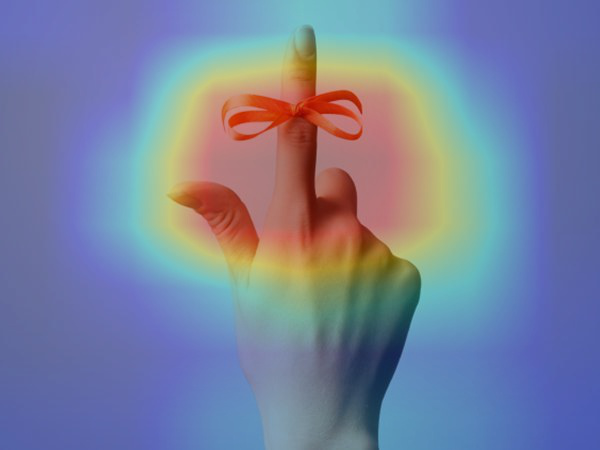

In [0]:
img

In [0]:
print(" memorablity score :",mem_score.item())

 memorablity score : 0.8099440336227417
